In [1]:
import os
import matplotlib.pyplot as plt
from typing import Tuple

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image

from tqdm import tqdm

from PIL import Image

> Attention : utilisation d'un répertoire de données en dehors de l'environnement do notebook !

torch.Size([1, 500, 334]) 255


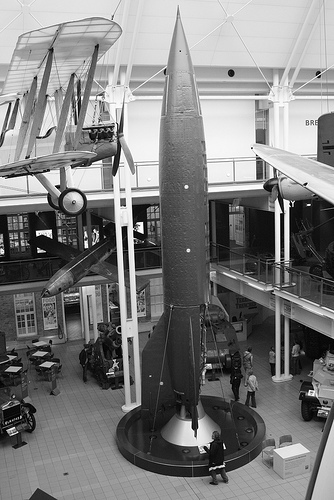

In [15]:
#DataPath = "/Users/me/Documents/Work/Dev/_data/imagene_val_images"
DataPath = "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master"
ImageFile = "n04008634_projectile.JPEG" #"ILSVRC2012_val_00038102_n01756291.JPEG" #"ILSVRC2012_val_00001971_n02105855.JPEG"
filename = os.path.join(DataPath, ImageFile)
img1_t = read_image(filename)
print(img1_t.size(), img1_t.max().item())
img1 = T.functional.to_pil_image(img1_t)
img1

1.0


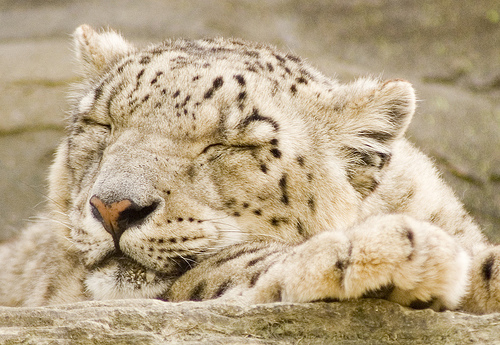

In [3]:
filename = os.path.join(DataPath, ImageFile)
input_image = Image.open(filename)
print(T.functional.to_tensor(input_image).max().item())
input_image

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str, transform: T.Compose=None, extension: str=".jpg"):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.extension = extension.lower()
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(self.extension)]


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        img_path = os.path.join(self.img_dir, self.files[idx])
        image = read_image(img_path)
        #print(self.files[idx], image.size(), end="")

        # If the image is not a RGB bit a 1 channel grey
        if image.size(0) == 1:
            print(self.files[idx])
            image = image.repeat(3, 1, 1)
            #print(image.size())
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.files[idx]


In [5]:
transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.),
    #T.ToTensor(),
])

imagenets = CustomImageDataset(DataPath, transform=transforms, extension=".JPEG")

In [6]:
len(imagenets)

1000

In [7]:
imageloader = DataLoader(imagenets, batch_size=128)

n04008634_projectile.JPEG
Feature batch shape: torch.Size([128, 3, 224, 224])
0.04313725605607033 0.9921568632125854


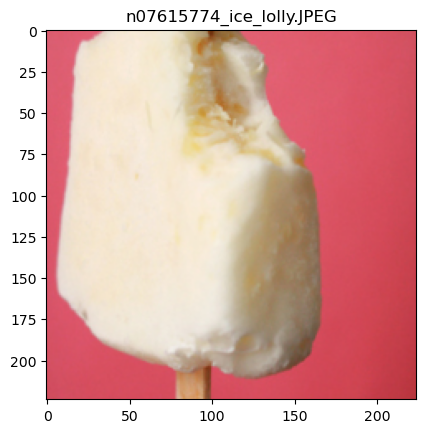

In [8]:
# Display image and label.
features, files= next(iter(imageloader))
print(f"Feature batch shape: {features.size()}")
img = features[0].squeeze()
file = files[0]
print(img.min().item(), img.max().item())
plt.imshow(F.to_pil_image(img))
plt.title(file)
plt.show()

n04008634_projectile.JPEG


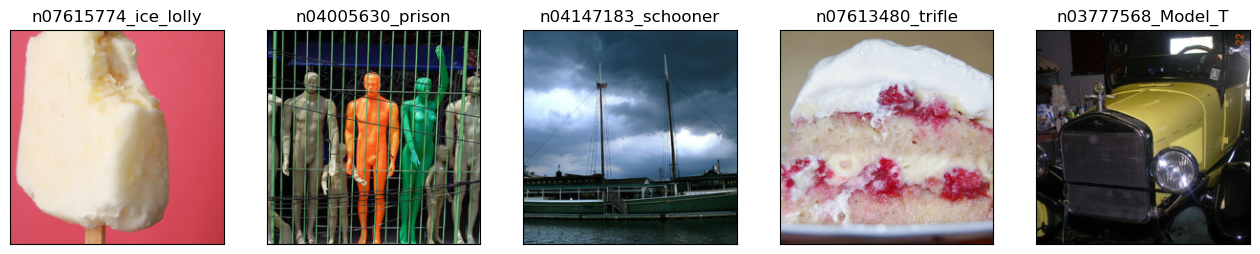

In [9]:
for batch_idx, inputs in enumerate(imageloader):
    fig = plt.figure(figsize = (16, 8))
    for i in range(5):
        ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
        plt.title(inputs[1][i].replace("ILSVRC2012_val_", "").replace(".JPEG", ""))
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break

In [10]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(imageloader):
    pictures = inputs[0]
    psum    += pictures.sum(axis        = [0, 2, 3])
    psum_sq += (pictures ** 2).sum(axis = [0, 2, 3])

  0%|          | 0/8 [00:00<?, ?it/s]

n04008634_projectile.JPEG


 12%|█▎        | 1/8 [00:00<00:03,  2.15it/s]

n04532670_viaduct.JPEG


 25%|██▌       | 2/8 [00:00<00:02,  2.06it/s]

n03992509_potter's_wheel.JPEG
n04554684_washer.JPEG
n04254680_soccer_ball.JPEG
n02823750_beer_glass.JPEG
n03388043_fountain.JPEG
n02692877_airship.JPEG


 38%|███▊      | 3/8 [00:01<00:02,  2.22it/s]

n02676566_acoustic_guitar.JPEG
n02096051_Airedale.JPEG


 50%|█████     | 4/8 [00:01<00:01,  2.26it/s]

n03697007_lumbermill.JPEG
n04371774_swing.JPEG
n02815834_beaker.JPEG
n03764736_milk_can.JPEG


 62%|██████▎   | 5/8 [00:02<00:01,  2.24it/s]

n04372370_switch.JPEG
n04356056_sunglasses.JPEG
n03692522_loupe.JPEG


 75%|███████▌  | 6/8 [00:02<00:00,  2.27it/s]

n02749479_assault_rifle.JPEG
n03417042_garbage_truck.JPEG
n03804744_nail.JPEG


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

n04090263_rifle.JPEG
n03908714_pencil_sharpener.JPEG


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

n03873416_paddle.JPEG


In [11]:
image_size = 224
count = len(imageloader.dataset) * image_size * image_size

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean:', total_mean.numpy())
print('- std: ', total_std.numpy())

Training data stats:
- mean: [0.49069783 0.4582515  0.40877318]
- std:  [0.26863348 0.2615253  0.2731904 ]


In [12]:
mean = [0.49069783, 0.4582515,  0.40877318]
std = [0.26863348, 0.2615253,  0.2731904]

# Source : https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [13]:
transforms2 = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.), # because read_image -> [0..255]
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

imagenets2 = CustomImageDataset(DataPath, transform=transforms2, extension=".JPEG")
imageloader2 = DataLoader(imagenets2, batch_size=128)

n04008634_projectile.JPEG


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


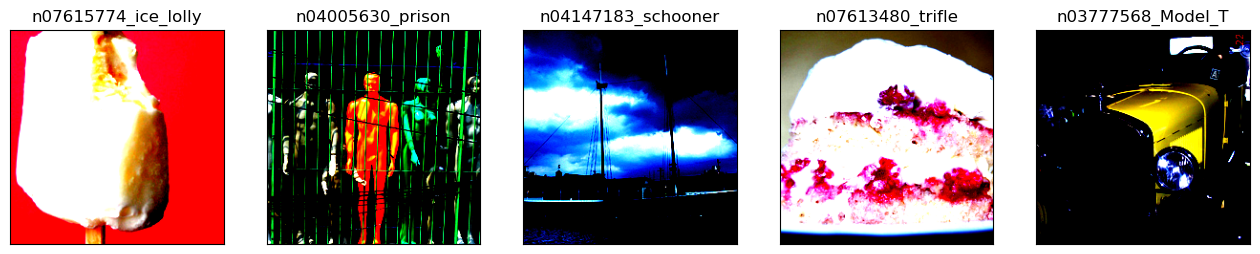

In [14]:
for batch_idx, inputs in enumerate(imageloader2):
    fig = plt.figure(figsize = (16, 8))
    for i in range(5):
        ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
        plt.title(inputs[1][i].replace("ILSVRC2012_val_", "").replace(".JPEG", ""))
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break